In [ ]:
!nvidia-smi

Mon Feb  6 14:45:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import os
import json

In [ ]:
import torch.nn as nn


In [ ]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT, progress=True)
model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier =nn.Sequential(
                  nn.Dropout(p=0.2, inplace=False),
                  nn.Linear(in_features=1280, out_features=1024),
                  nn.ReLU6(inplace=True),
                  nn.Linear(in_features=1024, out_features=37))
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
import torchvision.datasets as datasets

In [ ]:
WORKERS = 8

In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/train'

In [ ]:
from torchvision import datasets, transforms

In [ ]:


train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_images = datasets.ImageFolder(data_dir, transform=train_transform)


In [ ]:
train_images

Dataset ImageFolder
    Number of datapoints: 4807
    Root location: /content/drive/MyDrive/torch_ds/data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_loader = torch.utils.data.DataLoader(train_images,
                                            batch_size=32, shuffle=True, drop_last=True, 
                                            num_workers=WORKERS)

In [ ]:
image, label = next(iter(train_loader))
print(label[0])

tensor(9)


In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/val'
transform  = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_images = datasets.ImageFolder(data_dir, transform=transform)
val_loader = torch.utils.data.DataLoader(val_images,
                                          batch_size=32, shuffle=True, drop_last=True,
                                          num_workers=WORKERS)
val_loader


In [ ]:
data_dir = '/content/drive/MyDrive/torch_ds/data/test'
transform  = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_images = datasets.ImageFolder(data_dir, transform=transform)
test_loader = torch.utils.data.DataLoader(test_images,
                                          batch_size=32, 
                                          num_workers=6, 
                                          shuffle=True,
                                          drop_last=True)
test_loader

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import time
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [ ]:
import numpy as np

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
import sys
from tqdm import tqdm

In [ ]:
import torch.nn.functional as F

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, early_stopper, num_epochs=25, num_classes=1):
  
    since = time.perf_counter()

    val_acc_history = []
    val_loss_history = []

    lengths = {}
    for phase in ['train', 'val']:
        lengths[phase] = len(dataloaders[phase].dataset)
        print(f'{phase}_iters: {lengths[phase] // 32}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = float('inf')

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            lr = scheduler.optimizer.param_groups[0]['lr']
            running_loss = 0.0
            running_corrects = 0
            running_accuracy = 0.0

            with tqdm(dataloaders[phase], unit="batch", miniters=1) as tepoch:
                iter = 0
                for inputs, labels in tepoch:
                    iter += 1
                    if phase == 'train':
                        tepoch.set_description(f"Epoch {epoch + 1}")
                    else:
                        tepoch.set_description(f"Validation {epoch + 1}")

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = labels.type(torch.int64)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(torch.log_softmax(outputs, 1), 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
                    running_accuracy = running_corrects / (iter * 32)
                    tepoch.set_postfix(loss=loss.item(), accuracy=running_accuracy.item())

                epoch_loss = running_loss / lengths[phase]
                epoch_acc = running_corrects.double() / lengths[phase]

                print(f'{phase}_loss: {epoch_loss:.4f} {phase}_acc: {epoch_acc:.4f}')

                if phase == 'val':
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        
                    if min_loss - epoch_loss >= early_stopper.min_delta:
                        min_loss = epoch_loss
                        best_model_wts = copy.deepcopy(model.state_dict())
                        torch.save({'epoch': epoch, 
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'loss': epoch_loss}, '/content/drive/MyDrive/models/mnet2_multi.tar')

                    scheduler.step(epoch_loss)
                    val_acc_history.append(epoch_acc)
                    val_loss_history.append(epoch_loss)
                    print(f"lr: {lr:.0E}  min_loss: {min_loss:.4f}")

        epoch_end = time.perf_counter()
        time_elapsed =  epoch_end - epoch_start

        print(f'Epoch {epoch + 1} took {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        if early_stopper.early_stop(epoch_loss):             
            break
        
        print()

    time_elapsed = time.perf_counter() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val_acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history

In [ ]:
import torch.optim as optim

In [ ]:
for name, param in model.named_parameters():
      if param.requires_grad == True:
          print("\t",name)

	 classifier.1.weight
	 classifier.1.bias
	 classifier.3.weight
	 classifier.3.bias


In [ ]:
nadam = optim.NAdam(params=model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(nadam, patience=3, factor=0.1, threshold=1e-2, min_lr=1e-9)
criterion = nn.CrossEntropyLoss(label_smoothing=1e-2)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [ ]:
model = model.to(device)
model, val_acc_his, val_loss_his = train_model(model, dataloaders, criterion, nadam, scheduler,
            EarlyStopper(patience=3, min_delta=1e-2), num_classes=37, num_epochs=50)

train_iters: 150
val_iters: 46


Epoch 1: 100%|██████████| 150/150 [00:35<00:00,  4.17batch/s, accuracy=0.391, loss=2.29]


train_loss: 3.0815 train_acc: 0.3907


Validation 1: 100%|██████████| 46/46 [00:11<00:00,  3.91batch/s, accuracy=0.788, loss=1.85]


val_loss: 1.9954 val_acc: 0.7838
lr: 0.0001  min_loss: 1.9954
Epoch 1 took 0m 48s



Epoch 2: 100%|██████████| 150/150 [00:33<00:00,  4.50batch/s, accuracy=0.65, loss=1.27]


train_loss: 1.8853 train_acc: 0.6491


Validation 2: 100%|██████████| 46/46 [00:11<00:00,  3.93batch/s, accuracy=0.833, loss=1.08]


val_loss: 1.0415 val_acc: 0.8284
lr: 0.0001  min_loss: 1.0415
Epoch 2 took 0m 45s



Epoch 3: 100%|██████████| 150/150 [00:34<00:00,  4.34batch/s, accuracy=0.695, loss=1.07]


train_loss: 1.3761 train_acc: 0.6938


Validation 3: 100%|██████████| 46/46 [00:11<00:00,  3.92batch/s, accuracy=0.863, loss=0.742]


val_loss: 0.7435 val_acc: 0.8588
lr: 0.0001  min_loss: 0.7435
Epoch 3 took 0m 46s



Epoch 4: 100%|██████████| 150/150 [00:34<00:00,  4.40batch/s, accuracy=0.721, loss=0.976]


train_loss: 1.1726 train_acc: 0.7196


Validation 4: 100%|██████████| 46/46 [00:11<00:00,  4.07batch/s, accuracy=0.865, loss=0.594]


val_loss: 0.6289 val_acc: 0.8601
lr: 0.0001  min_loss: 0.6289
Epoch 4 took 0m 46s



Epoch 5: 100%|██████████| 150/150 [00:35<00:00,  4.28batch/s, accuracy=0.723, loss=1.32]


train_loss: 1.0931 train_acc: 0.7217


Validation 5: 100%|██████████| 46/46 [00:11<00:00,  4.05batch/s, accuracy=0.875, loss=0.381]


val_loss: 0.5552 val_acc: 0.8703
lr: 0.0001  min_loss: 0.5552
Epoch 5 took 0m 47s



Epoch 6: 100%|██████████| 150/150 [00:31<00:00,  4.69batch/s, accuracy=0.737, loss=1.52]


train_loss: 1.0303 train_acc: 0.7356


Validation 6: 100%|██████████| 46/46 [00:11<00:00,  4.17batch/s, accuracy=0.884, loss=0.386]


val_loss: 0.5247 val_acc: 0.8791
lr: 0.0001  min_loss: 0.5247
Epoch 6 took 0m 43s



Epoch 7: 100%|██████████| 150/150 [00:32<00:00,  4.63batch/s, accuracy=0.744, loss=1.57]


train_loss: 0.9802 train_acc: 0.7427


Validation 7: 100%|██████████| 46/46 [00:11<00:00,  4.17batch/s, accuracy=0.891, loss=0.516]


val_loss: 0.5074 val_acc: 0.8858
lr: 0.0001  min_loss: 0.5074
Epoch 7 took 0m 44s



Epoch 8: 100%|██████████| 150/150 [00:32<00:00,  4.61batch/s, accuracy=0.749, loss=0.7]


train_loss: 0.9665 train_acc: 0.7475


Validation 8: 100%|██████████| 46/46 [00:10<00:00,  4.21batch/s, accuracy=0.888, loss=0.454]


val_loss: 0.4978 val_acc: 0.8831
lr: 0.0001  min_loss: 0.5074
Epoch 8 took 0m 44s



Epoch 9: 100%|██████████| 150/150 [00:31<00:00,  4.73batch/s, accuracy=0.759, loss=0.749]


train_loss: 0.9030 train_acc: 0.7581


Validation 9: 100%|██████████| 46/46 [00:12<00:00,  3.56batch/s, accuracy=0.887, loss=0.265]


val_loss: 0.4863 val_acc: 0.8818
lr: 0.0001  min_loss: 0.4863
Epoch 9 took 0m 45s



Epoch 10: 100%|██████████| 150/150 [00:31<00:00,  4.76batch/s, accuracy=0.768, loss=0.8]


train_loss: 0.8943 train_acc: 0.7672


Validation 10: 100%|██████████| 46/46 [00:10<00:00,  4.25batch/s, accuracy=0.897, loss=0.414]


val_loss: 0.4580 val_acc: 0.8919
lr: 0.0001  min_loss: 0.4580
Epoch 10 took 0m 43s



Epoch 11: 100%|██████████| 150/150 [00:31<00:00,  4.74batch/s, accuracy=0.776, loss=0.565]


train_loss: 0.8766 train_acc: 0.7751


Validation 11: 100%|██████████| 46/46 [00:10<00:00,  4.24batch/s, accuracy=0.891, loss=0.311]


val_loss: 0.4577 val_acc: 0.8858
lr: 0.0001  min_loss: 0.4580
Epoch 11 took 0m 43s



Epoch 12: 100%|██████████| 150/150 [00:31<00:00,  4.78batch/s, accuracy=0.771, loss=0.815]


train_loss: 0.8743 train_acc: 0.7695


Validation 12: 100%|██████████| 46/46 [00:10<00:00,  4.30batch/s, accuracy=0.894, loss=0.464]


val_loss: 0.4550 val_acc: 0.8892
lr: 0.0001  min_loss: 0.4580
Epoch 12 took 0m 42s



Epoch 13: 100%|██████████| 150/150 [00:31<00:00,  4.81batch/s, accuracy=0.766, loss=0.742]


train_loss: 0.8754 train_acc: 0.7653


Validation 13: 100%|██████████| 46/46 [00:10<00:00,  4.29batch/s, accuracy=0.894, loss=0.42]


val_loss: 0.4422 val_acc: 0.8892
lr: 0.0001  min_loss: 0.4422
Epoch 13 took 0m 42s



Epoch 14: 100%|██████████| 150/150 [00:33<00:00,  4.53batch/s, accuracy=0.783, loss=0.679]


train_loss: 0.8331 train_acc: 0.7818


Validation 14: 100%|██████████| 46/46 [00:10<00:00,  4.28batch/s, accuracy=0.897, loss=0.731]


val_loss: 0.4396 val_acc: 0.8926
lr: 0.0001  min_loss: 0.4422
Epoch 14 took 0m 44s



Epoch 15: 100%|██████████| 150/150 [00:31<00:00,  4.80batch/s, accuracy=0.784, loss=0.586]


train_loss: 0.8280 train_acc: 0.7830


Validation 15: 100%|██████████| 46/46 [00:10<00:00,  4.29batch/s, accuracy=0.894, loss=0.352]


val_loss: 0.4420 val_acc: 0.8892
lr: 0.0001  min_loss: 0.4422
Epoch 15 took 0m 42s



Epoch 16: 100%|██████████| 150/150 [00:31<00:00,  4.75batch/s, accuracy=0.795, loss=0.562]


train_loss: 0.7979 train_acc: 0.7936


Validation 16: 100%|██████████| 46/46 [00:10<00:00,  4.28batch/s, accuracy=0.901, loss=0.379]


val_loss: 0.4300 val_acc: 0.8966
lr: 0.0001  min_loss: 0.4300
Epoch 16 took 0m 42s



Epoch 17: 100%|██████████| 150/150 [00:31<00:00,  4.76batch/s, accuracy=0.788, loss=0.814]


train_loss: 0.8022 train_acc: 0.7864


Validation 17: 100%|██████████| 46/46 [00:11<00:00,  4.15batch/s, accuracy=0.893, loss=0.389]


val_loss: 0.4477 val_acc: 0.8878
lr: 0.0001  min_loss: 0.4300
Epoch 17 took 0m 43s



Epoch 18: 100%|██████████| 150/150 [00:34<00:00,  4.41batch/s, accuracy=0.798, loss=0.848]


train_loss: 0.7927 train_acc: 0.7968


Validation 18: 100%|██████████| 46/46 [00:10<00:00,  4.23batch/s, accuracy=0.906, loss=0.484]


val_loss: 0.4151 val_acc: 0.9014
lr: 0.0001  min_loss: 0.4151
Epoch 18 took 0m 45s



Epoch 19: 100%|██████████| 150/150 [00:31<00:00,  4.72batch/s, accuracy=0.786, loss=0.881]


train_loss: 0.8070 train_acc: 0.7847


Validation 19: 100%|██████████| 46/46 [00:11<00:00,  4.17batch/s, accuracy=0.899, loss=0.399]


val_loss: 0.4235 val_acc: 0.8939
lr: 0.0001  min_loss: 0.4151
Epoch 19 took 0m 43s



Epoch 20: 100%|██████████| 150/150 [00:31<00:00,  4.71batch/s, accuracy=0.789, loss=0.86]


train_loss: 0.7768 train_acc: 0.7878


Validation 20: 100%|██████████| 46/46 [00:11<00:00,  4.16batch/s, accuracy=0.898, loss=0.379]


val_loss: 0.4232 val_acc: 0.8932
lr: 0.0001  min_loss: 0.4151
Epoch 20 took 0m 43s



Epoch 21: 100%|██████████| 150/150 [00:32<00:00,  4.68batch/s, accuracy=0.799, loss=0.641]


train_loss: 0.7737 train_acc: 0.7974


Validation 21: 100%|██████████| 46/46 [00:10<00:00,  4.25batch/s, accuracy=0.897, loss=0.575]


val_loss: 0.4243 val_acc: 0.8919
lr: 0.0001  min_loss: 0.4151
Epoch 21 took 0m 43s



Epoch 22: 100%|██████████| 150/150 [00:32<00:00,  4.64batch/s, accuracy=0.792, loss=0.84]


train_loss: 0.7793 train_acc: 0.7905


Validation 22: 100%|██████████| 46/46 [00:11<00:00,  4.11batch/s, accuracy=0.9, loss=0.411]


val_loss: 0.4261 val_acc: 0.8953
lr: 0.0001  min_loss: 0.4151
Epoch 22 took 0m 44s



Epoch 23: 100%|██████████| 150/150 [00:33<00:00,  4.42batch/s, accuracy=0.809, loss=0.971]


train_loss: 0.7296 train_acc: 0.8076


Validation 23: 100%|██████████| 46/46 [00:10<00:00,  4.22batch/s, accuracy=0.898, loss=0.368]


val_loss: 0.4204 val_acc: 0.8932
lr: 1e-05  min_loss: 0.4151
Epoch 23 took 0m 45s



Epoch 24: 100%|██████████| 150/150 [00:31<00:00,  4.73batch/s, accuracy=0.801, loss=0.659]


train_loss: 0.7589 train_acc: 0.7995


Validation 24: 100%|██████████| 46/46 [00:11<00:00,  4.18batch/s, accuracy=0.897, loss=0.555]


val_loss: 0.4187 val_acc: 0.8919
lr: 1e-05  min_loss: 0.4151
Epoch 24 took 0m 43s



Epoch 25: 100%|██████████| 150/150 [00:31<00:00,  4.76batch/s, accuracy=0.795, loss=0.603]


train_loss: 0.7697 train_acc: 0.7934


Validation 25: 100%|██████████| 46/46 [00:10<00:00,  4.26batch/s, accuracy=0.905, loss=0.466]


val_loss: 0.4108 val_acc: 0.9000
lr: 1e-05  min_loss: 0.4151
Epoch 25 took 0m 42s



Epoch 26: 100%|██████████| 150/150 [00:31<00:00,  4.75batch/s, accuracy=0.805, loss=0.897]


train_loss: 0.7669 train_acc: 0.8042


Validation 26: 100%|██████████| 46/46 [00:10<00:00,  4.24batch/s, accuracy=0.902, loss=0.269]


val_loss: 0.4101 val_acc: 0.8973
lr: 1e-05  min_loss: 0.4151
Epoch 26 took 0m 42s



Epoch 27: 100%|██████████| 150/150 [00:33<00:00,  4.50batch/s, accuracy=0.8, loss=0.665]


train_loss: 0.7662 train_acc: 0.7986


Validation 27: 100%|██████████| 46/46 [00:10<00:00,  4.23batch/s, accuracy=0.904, loss=0.512]


val_loss: 0.4037 val_acc: 0.8986
lr: 1e-05  min_loss: 0.4037
Epoch 27 took 0m 44s



Epoch 28: 100%|██████████| 150/150 [00:31<00:00,  4.75batch/s, accuracy=0.805, loss=0.475]


train_loss: 0.7482 train_acc: 0.8040


Validation 28: 100%|██████████| 46/46 [00:10<00:00,  4.25batch/s, accuracy=0.899, loss=0.376]


val_loss: 0.4143 val_acc: 0.8939
lr: 1e-05  min_loss: 0.4037
Epoch 28 took 0m 42s



Epoch 29: 100%|██████████| 150/150 [00:31<00:00,  4.76batch/s, accuracy=0.798, loss=0.851]


train_loss: 0.7690 train_acc: 0.7970


Validation 29: 100%|██████████| 46/46 [00:10<00:00,  4.21batch/s, accuracy=0.901, loss=0.443]


val_loss: 0.4111 val_acc: 0.8959
lr: 1e-05  min_loss: 0.4037
Epoch 29 took 0m 42s



Epoch 30: 100%|██████████| 150/150 [00:31<00:00,  4.75batch/s, accuracy=0.814, loss=0.933]


train_loss: 0.7302 train_acc: 0.8126


Validation 30: 100%|██████████| 46/46 [00:10<00:00,  4.25batch/s, accuracy=0.906, loss=0.492]


val_loss: 0.4049 val_acc: 0.9007
lr: 1e-05  min_loss: 0.4037
Epoch 30 took 0m 42s



Epoch 31: 100%|██████████| 150/150 [00:31<00:00,  4.74batch/s, accuracy=0.812, loss=0.91]


train_loss: 0.7252 train_acc: 0.8105


Validation 31: 100%|██████████| 46/46 [00:12<00:00,  3.62batch/s, accuracy=0.904, loss=0.541]


val_loss: 0.4149 val_acc: 0.8986
lr: 1e-05  min_loss: 0.4037
Epoch 31 took 0m 44s



Epoch 32: 100%|██████████| 150/150 [00:32<00:00,  4.67batch/s, accuracy=0.807, loss=0.782]


train_loss: 0.7397 train_acc: 0.8055


Validation 32: 100%|██████████| 46/46 [00:11<00:00,  4.07batch/s, accuracy=0.902, loss=0.388]


val_loss: 0.4101 val_acc: 0.8973
lr: 1.0000000000000002e-06  min_loss: 0.4037
Epoch 32 took 0m 43s



Epoch 33: 100%|██████████| 150/150 [00:31<00:00,  4.77batch/s, accuracy=0.805, loss=0.479]


train_loss: 0.7420 train_acc: 0.8040


Validation 33: 100%|██████████| 46/46 [00:10<00:00,  4.24batch/s, accuracy=0.903, loss=0.552]


val_loss: 0.4123 val_acc: 0.8980
lr: 1.0000000000000002e-06  min_loss: 0.4037
Epoch 33 took 0m 42s



Epoch 34: 100%|██████████| 150/150 [00:31<00:00,  4.78batch/s, accuracy=0.81, loss=0.819]


train_loss: 0.7280 train_acc: 0.8086


Validation 34: 100%|██████████| 46/46 [00:10<00:00,  4.28batch/s, accuracy=0.899, loss=0.28]


val_loss: 0.4056 val_acc: 0.8939
lr: 1.0000000000000002e-06  min_loss: 0.4037
Epoch 34 took 0m 42s



Epoch 35: 100%|██████████| 150/150 [00:31<00:00,  4.76batch/s, accuracy=0.799, loss=0.777]


train_loss: 0.7576 train_acc: 0.7974


Validation 35: 100%|██████████| 46/46 [00:10<00:00,  4.23batch/s, accuracy=0.899, loss=0.279]

val_loss: 0.4167 val_acc: 0.8939
lr: 1.0000000000000002e-06  min_loss: 0.4037
Epoch 35 took 0m 42s
Training complete in 25m 24s
Best val_acc: 0.901351


In [ ]:
def test_model(model, test_dataloader, criterion):
    model.eval()

    since = time.perf_counter()

    running_loss = 0.0
    running_corrects = 0
    all_preds = np.array([])
    all_labels = np.array([])

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.type(torch.int64)

        with torch.no_grad():  
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(torch.log_softmax(outputs, 1), 1)
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(torch.round(preds)==labels.data)

        labels = labels.to(torch.device('cpu'))
        preds = preds.to(torch.device('cpu'))

        labels_np = labels.detach().numpy()
        labels_np = np.reshape(labels_np, -1)
        all_labels = np.append(all_labels, labels_np, axis=0)

        preds_np = preds.detach().numpy()
        preds_np = np.reshape(preds_np, -1)
        all_preds = np.append(all_preds, preds_np, axis=0)

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}\n')

    print(f'Tested in {(time.perf_counter() - since):.1f}s')
    
    return all_preds, all_labels

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/models/mnet2_multi.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model = model.to(device)

In [ ]:
all_preds, all_labels = test_model(model, test_loader, nn.CrossEntropyLoss())

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

with open('/content/drive/MyDrive/torch_ds/data/annotations/breed_dict.json', 'rb') as f:
    breed_dict = json.load(f)


test_loss: 0.3252 test_acc: 0.8794

Tested in 9.3s


                                 precision    recall  f1-score   support

                 (1) Abyssinian       0.77      0.77      0.77        30
           (2) american bulldog       0.73      0.80      0.76        30
  (3) american pit bull terrier       0.93      0.87      0.90        30
               (4) basset hound       0.94      1.00      0.97        30
                     (5) beagle       1.00      0.86      0.93        29
                     (6) Bengal       0.97      1.00      0.98        30
                     (7) Birman       0.88      1.00      0.94        29
                     (8) Bombay       0.91      1.00      0.95        30
                      (9) boxer       0.96      0.96      0.96        27
         (10) British Shorthair       0.93      0.93      0.93        29
                 (11) chihuahua       0.85      0.88      0.86        32
              (12) Egyptian Mau       0.91      0.97      0.94        30
    (13) english cocker spaniel       0.76      0.

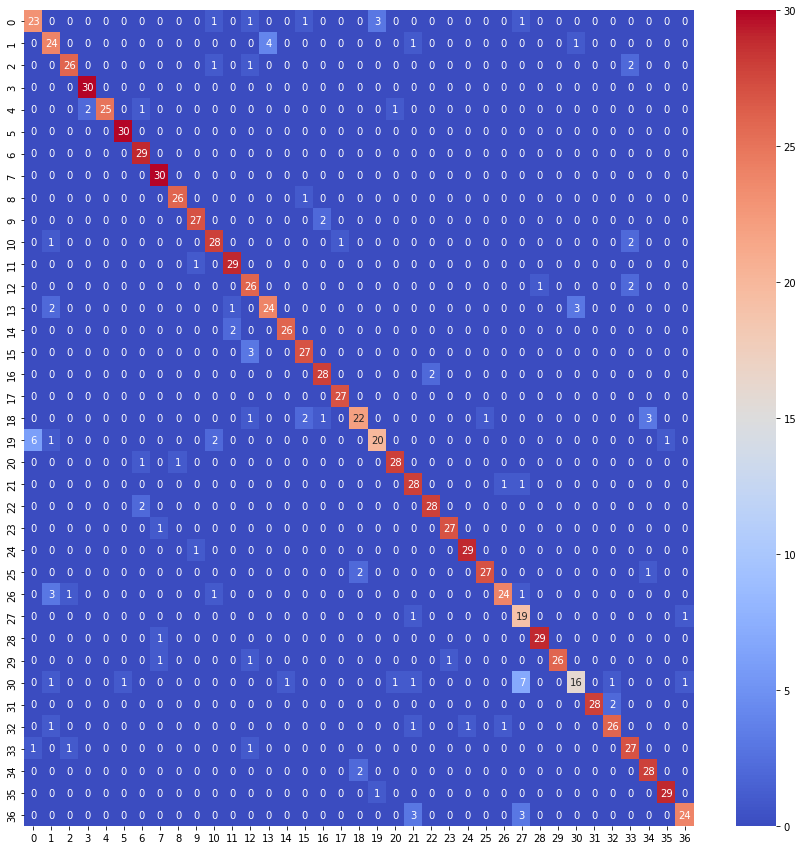

In [ ]:
targets = [f'({key}) {value}' for key, value in breed_dict.items()]

print(classification_report(all_labels, all_preds, target_names=targets))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.show()